# Определение тарифа

## Импорт и изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import math as mt
import numpy as np
import seaborn as sns

In [2]:
users = pd.read_csv('users.csv')
messages = pd.read_csv('messages.csv')
internet = pd.read_csv('internet.csv')
calls = pd.read_csv('calls.csv')
tariffs = pd.read_csv('tariffs.csv')

try:
    users = pd.read_csv('users.csv')
    messages = pd.read_csv('messages.csv')
    internet = pd.read_csv('internet.csv')
    calls = pd.read_csv('calls.csv')
    tariffs = pd.read_csv('tariffs.csv')

except:
    users = pd.read_csv('/datasets/calls.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    calls = pd.read_csv('/datasets/calls.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')

### Таблица _users.csv_

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [5]:
ultra_cnt = len(users.query('tariff == "ultra"'))
smart_cnt = len(users.query('tariff == "smart"'))
print(f'Количество абонентов тарифа "Смарт" в выборке: {smart_cnt}')
print(f'Количество абонентов тарифа "Ультра" в выборке: {ultra_cnt}')

Количество абонентов тарифа "Смарт" в выборке: 351
Количество абонентов тарифа "Ультра" в выборке: 149


Наиболее важная особенность: __в выборке более чем в два раза больше пользователей тарифа "Смарт"__ -  более бюджетного варианта. 
Описание пользователей содержит пропуски только в колонке _churn_date_. Возникновение пропусков связано с тем, что на момент сбора данных абонент еще использовал тариф. Удаление пропусков не нужно.  
Перед работой будет необходимо заменить типы данных в колонках _churn_date_, _reg_date_.  
Помимо этого в таблицу будет добавлена колонка _is_active_, содержащая значения True/False, отражающая факт пользования тарифом на момент выгрузки данных.  

### Таблица _messages.csv_.

In [6]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [7]:
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


В таблице _messages_ необходимо привести данные в колонке _message_date_ к типу datetime[64].  
Также важно, что колонка _id_ не будет подвергнута каким-либо изменениям за их ненадобностью. 

### Таблица _calls.csv_.

In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [9]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


В таблице _calls.csv_ необходимо заменить тип данных в колонке _call_date_ на datetime[64].  
Данные в колонке _duration_ нужно будет привести к целому количеству минут.  
Помимо этого, важно учитывать, что _0_ в колонке _duration_ соответствует несостоявшемуся звонку. 

### Таблица _internet.csv_.

In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [11]:
internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


В таблице _internet.csv_ необходимо заменить тип данных в колонке _session_date_ на тип datetime[64].  
Данные в колонке _mb_used_ нужно привести к типу int[64] с округлением в бОльшую сторону.  
Помимо этого, в таблице присутствует колонка _Unnamed: 0_, возникшая, вероятно, при выгрузке данных и содержащая дубли индексов записей. Колонка будет удалена.  
Колонка _id_ менятся не будет

### Таблица _tariffs.csv_.

In [12]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [13]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Данные в таблице _tariffs.csv_ в редактировании не нуждаются. 

### Промежуточный вывод. 
В ходе поверхностного знакомства с данными в первом приближении были сформулированы требования по __очистке__ данных, __замене типов__ данных, а также __выявлены особенности и__ явные __ошибки__ в исходных данных. 

## План выполнения проекта
1. Проведение предобработки данных: 
 1. - [x] Удаление лишних столбцов
 2. - [x] Замена типов данных
 3. - [x] Обработка пропусков
 4. - [x] Добавление новых столбцов в случае необходимости
 5. - [x] Промежуточный вывод
2. Проведение расчетов (для каждого пользователя): 
 1. - [x] Количество сделанных звонков и израсходованных минут разговора по месяцам
 2. - [x] Количество отправленных сообщений по месяцам
 3. - [x] Объем израсходованного интернет-трафика по месяцам
 4. - [x] Помесячную выручку с каждого пользователя
 5. - [x] Промежуточный вывод
3. Анализ статистик выборки:
 1. - [x] Очистка сформированной(-ых) таблицы(-ц) от выбросов
 1. - [x] Средние значения
 2. - [x] Дисперсии, стандартные отклонения
 3. - [x] Построение частотных диаграм и кривых распределения плотностей вероятности
 4. - [x] Описание распределений
 5. - [x] Расчет вероятности получения дополнительной прибыли с каждого пользователя
 6. - [x] Промежуточный вывод
4. Проверка гипотез:
 1. - [x] Формулирование нулевых и альтернативных гипотез
 2. - [x] Проведение статистических тестов
 3. - [x] Промежуточный вывод
5. - [x] Общий вывод
  

## Предобработка данных

### Удаление столбцов. 
В таблице _internet.csv_ присутствует колонка, не имеющая смысла и подлежащая удалению.  
Возникновение колонки связано, вероятнее всего, с ошибкой в алгоритме выгрузки данных.

In [14]:
internet = internet.drop(columns=['Unnamed: 0'])

### Замена типов данных. 
Замена будет выполнена в соответствии с ранее сделанными выводами.  
##### Таблица _users.csv_. 
1. Введение формата _datetime64_
2. Добавление колонки _is_active_, содержашей информацию о статусе пользования тарифом

In [15]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['is_active'] = users['churn_date'].isna()
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
 8   is_active   500 non-null    bool          
dtypes: bool(1), datetime64[ns](2), int64(2), object(4)
memory usage: 31.9+ KB


##### Таблица _messages.csv_.
1. Введение формата _datetime64_

In [16]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


##### Таблица _calls.csv_. 
1. Введение формата _datetime64_
2. Округление данных о продолжительности звонка в бОльшую сторону и приведение к типу _int64_ 

In [17]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['duration'] = np.ceil(calls['duration']).astype('int64')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


##### Таблица _internet.csv_.
1. Введение формата _datetime64_
2. Округление объема интернет-трафика в бОльшую сторону и приведение к типу _int64_

In [18]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['mb_used'] = np.ceil(internet['mb_used']).astype('int64')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  int64         
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.6+ MB


### Нулевые значения продолжительности звонков и объема использованного трафика. 

#### Таблица _calls.csv_.
__Ключевой параметр, исследуемый в проекте - экономическая эффективность тарифов.__  
Согласно политике ценообразования, за звонок, продолжительностью в 0 секунд, абонент не платит, помимо этого, такие звонки не расходуют ресурс минут тарифа.  
Следовательно, при исследовании прибыльности тарифа, __случаи с нулевой продолжительностью звонка рассматривать нельзя.__ С точки зрения статистики, сохранение записей о звонках с нулевой продолжительностью приведет к __смещению статистик выборки__ в меньшую сторону.  
  
_Примечание_: было проведено сравнение результатов дальнейшего исследования для датасетов с сохраненными нулевыми значениями и без них. Разница в полученных значениях не превысила сотой процента для каждого из показателей. Вероятнее всего, это связано с тем, что при расчетах данные группируются по месяцам и влияение нулевых значений практически полностью нивелируется. 

In [19]:
calls_len_before = len(calls)
calls = calls.query('duration != 0').reset_index(drop=True)
calls_len_after = len(calls)
calls_len_reduce = round(100 * (calls_len_before - calls_len_after) / calls_len_before, 2)
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162994 entries, 0 to 162993
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         162994 non-null  object        
 1   call_date  162994 non-null  datetime64[ns]
 2   duration   162994 non-null  int64         
 3   user_id    162994 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.0+ MB


In [20]:
internet_len_before = len(internet)
internet = internet.query('mb_used != 0').reset_index(drop=True)
internet_len_after = len(internet)
internet_len_reduce = round(100 * (internet_len_before - internet_len_after) / internet_len_before, 2)
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129798 entries, 0 to 129797
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            129798 non-null  object        
 1   mb_used       129798 non-null  int64         
 2   session_date  129798 non-null  datetime64[ns]
 3   user_id       129798 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.0+ MB


In [21]:
print(f'Сокращение датасета calls составило {calls_len_reduce}%')
print(f'Сокращение датасета internet составило {internet_len_reduce}%')

Сокращение датасета calls составило 19.55%
Сокращение датасета internet составило 13.12%


#### Таблица _users.csv_. 
Данная таблица единственная из всего набора содержит пропуски.  
Однако, согласно техническому заданию, пропуски возникли в результате особенностей алгоритма выгрузки данных и в расчете (на данном этапе) ни на что не влияют.  
В случае возникновения необходимости, пропуски будут удалены в дальнейшем. 

### Добавление новых столбцов. 

Во все таблицы, содержащие данные типа _datetime_ будут добавлены колонки _month_num_ и _month_name_, отвечающие за номер месяца и его название соответственно. 

In [22]:
users['month_num'] = users['reg_date'].dt.month
users['month_name'] = users['reg_date'].dt.month_name()

messages['month_num'] = messages['message_date'].dt.month
messages['month_name'] = messages['message_date'].dt.month_name()

calls['month_num'] = calls['call_date'].dt.month
calls['month_name'] = calls['call_date'].dt.month_name()

internet['month_num'] = internet['session_date'].dt.month
internet['month_name'] = internet['session_date'].dt.month_name()

### Промежуточный вывод. 
В ходе предобработки данных: 
1. Была произведена замена типов (введены типы datetime64, int64) 
2. Количества звонков и израсходованного интернет-трафика были перерассчитаны с учетом политики ценообразования компании
3. Была удалена лишняя колонка в таблице _internet.csv_
4. В имеющиеся таблицы с информацией о датах были добавлены колонки, отвечающие за номер месяца и его название. 

## Расчеты. 

### Количество сделанных звонков и израсходованных минут разговора по месяцам. Дополнительная прибыль от звонков. 
При выполнении этого пункта будет использоваться датасет _calls_, содержащий нулевые значения в поле продолжительности звонка (_duration_).  
__Последовательность действий:__
1. В таблицу _calls_ добавляется информация о тарифе пользователя
2. В таблицу вносится информация о лимите минут (колонка _tariff_time_limit_)
3. Таблица _calls_ группируется по пользователям, затем по месяцам, в полученный датасет вносятся данные по количеству звонков и общей месячной продолжительности разговоров (колонки _call_count_ и _duration_sum_ соответственно)
4. В сгруппированную таблицу добавляются колонки с превышением лимита (отрицательное превышение = отсутствие превышения лимита, колонка _time_excess_)
5. Исходя из превышения лимита расчитывается дополнительная прибыль (колонка _calls_extra_net_worth_). 

Добавление информации о тарифе пользователя в таблицу _calls_

In [23]:
def tariff_time_lim(row):
    """
    Функция определяет количество бесплатных минут, соответствующее тарифу пользователя. 
    row: строка датасета calls
    return: количество бесплатных минут
    """
    if row['tariff'] == 'ultra':
        return 3000
    else: 
        return 500


calls = calls.merge(users[['user_id','tariff']], how='left', on='user_id')
calls['tariff_time_limit'] = calls.apply(tariff_time_lim, axis=1)
calls

,id,call_date,duration,user_id,month_num,month_name,tariff,tariff_time_limit
0,1000_2,2018-06-11,3,1000,6,June,ultra,3000
1,1000_3,2018-09-21,14,1000,9,September,ultra,3000
2,1000_4,2018-12-15,6,1000,12,December,ultra,3000
3,1000_7,2018-08-22,19,1000,8,August,ultra,3000
4,1000_8,2018-09-15,19,1000,9,September,ultra,3000
...,...,...,...,...,...,...,...,...
162989,1499_215,2018-12-26,1,1499,12,December,smart,500
162990,1499_216,2018-10-18,19,1499,10,October,smart,500
162991,1499_217,2018-11-10,11,1499,11,November,smart,500
162992,1499_218,2018-10-06,5,1499,10,October,smart,500


Группировка таблицы _calls_ по пользователям и месяцам и добавление новой колонки.  
Итог: __датафрейм _calls_pivot___ (описание колонок - выше)

In [24]:
calls_pivot = (calls.pivot_table(index=['user_id', 'month_num'], values=['id', 'duration', 'tariff_time_limit'], 
                                 aggfunc={'id': 'count', 'duration': 'sum', 'tariff_time_limit': 'last'})
                    .rename(columns={'duration': 'duration_sum', 'id': 'call_count'}))
calls_pivot['time_excess'] = calls_pivot['duration_sum'] - calls_pivot['tariff_time_limit']
calls_pivot

duration_sum  call_count  tariff_time_limit  time_excess
user_id month_num                                                          
1000    5                   159          17               3000        -2841
        6                   172          28               3000        -2828
        7                   340          41               3000        -2660
        8                   408          42               3000        -2592
        9                   466          46               3000        -2534
...                         ...         ...                ...          ...
1498    10                  247          30                500         -253
1499    9                    70           8                500         -430
        10                  449          44                500          -51
        11                  612          62                500          112
        12                  492          56                500           -8

[3168 rows x 4 columns]

In [25]:
def calls_extra_net_worth(row):
    """
    Функция определяет дополнительную выручку от звонков для конкретного пользователя за конкретный месяц. 
    
    row: строка датасета calls_pivot
    return: значение дополнительной месячной прибыли от звонков
    """
    if row['time_excess'] <= 0:
        return 0
    elif row['time_excess'] > 0:
        if row['tariff_time_limit'] == 500:
            return 3 * row['time_excess']
        elif row['tariff_time_limit'] == 3000:
            return row['time_excess']


calls_pivot['calls_extra_net_worth'] = calls_pivot.apply(calls_extra_net_worth, axis=1)
calls_pivot

duration_sum  call_count  tariff_time_limit  time_excess  \
user_id month_num                                                             
1000    5                   159          17               3000        -2841   
        6                   172          28               3000        -2828   
        7                   340          41               3000        -2660   
        8                   408          42               3000        -2592   
        9                   466          46               3000        -2534   
...                         ...         ...                ...          ...   
1498    10                  247          30                500         -253   
1499    9                    70           8                500         -430   
        10                  449          44                500          -51   
        11                  612          62                500          112   
        12                  492          56                500           -8   

                   calls_extra_net_worth  
user_id month_num                         
1000    5                              0  
        6                              0  
        7                              0  
        8                              0  
        9                              0  
...                                  ...  
1498    10                             0  
1499    9                              0  
        10                             0  
        11                           336  
        12                             0  

[3168 rows x 5 columns]

### Количество отправленных сообщений по месяцам. 

__Последовательность действий:__
1. В таблицу _messages_ добавляется информация о тарифе пользователя
2. В таблицу вносится информация о лимите сообщений (колонка _tariff_msg_limit_)
3. Таблица _messages_ группируется по пользователям, затем по месяцам, в полученный датасет вносятся данные по количеству сообщений (колонка _msg_count_)
4. В сгруппированную таблицу добавляются колонки с превышением лимита (отрицательное превышение = отсутствие превышения лимита, колонка _msg_excess_)
5. Исходя из превышения лимита расчитывается дополнительная прибыль (колонка _msg_extra_net_worth_). 

In [26]:
def tariff_msg_lim(row):
    if row['tariff'] == 'ultra':
        return 1000
    else: 
        return 50


messages = messages.merge(users[['user_id', 'tariff']], how='left', on='user_id')
messages['tariff_msg_limit'] = messages.apply(tariff_msg_lim, axis=1)
messages.head()

,id,message_date,user_id,month_num,month_name,tariff,tariff_msg_limit
0,1000_0,2018-06-27,1000,6,June,ultra,1000
1,1000_1,2018-10-08,1000,10,October,ultra,1000
2,1000_2,2018-08-04,1000,8,August,ultra,1000
3,1000_3,2018-06-16,1000,6,June,ultra,1000
4,1000_4,2018-12-05,1000,12,December,ultra,1000


Итог: датафрейм ___messages_pivot___ (описание колонок - выше)

In [27]:
def msg_extra_net_worth(row):
    if row['msg_excess'] <= 0:
        return 0
    elif row['msg_excess'] > 0:
        if row['tariff_msg_limit'] == 50:
            return 3 * row['msg_excess']
        elif row['tariff_msg_limit'] == 1000:
            return row['msg_excess']


messages_pivot = (messages.pivot_table(index=['user_id', 'month_num'], values=['id', 'tariff_msg_limit'], 
                                       aggfunc={'id': 'count', 'tariff_msg_limit': 'last'})
                          .rename(columns={'id': 'message_count'}))
messages_pivot['msg_excess'] = messages_pivot['message_count'] - messages_pivot['tariff_msg_limit']
messages_pivot['msg_extra_net_worth'] = messages_pivot.apply(msg_extra_net_worth, axis=1)
messages_pivot

message_count  tariff_msg_limit  msg_excess  \
user_id month_num                                                
1000    5                     22              1000        -978   
        6                     60              1000        -940   
        7                     75              1000        -925   
        8                     81              1000        -919   
        9                     57              1000        -943   
...                          ...               ...         ...   
1498    10                    42                50          -8   
1499    9                     11                50         -39   
        10                    48                50          -2   
        11                    59                50           9   
        12                    66                50          16   

                   msg_extra_net_worth  
user_id month_num                       
1000    5                            0  
        6                            0  
        7                            0  
        8                            0  
        9                            0  
...                                ...  
1498    10                           0  
1499    9                            0  
        10                           0  
        11                          27  
        12                          48  

[2717 rows x 4 columns]

### Объем израсходованного интернет-трафика по месяцам. 

Расчет дополнительной прибыли от интернет трафика проходит аналогично звонкам и сообщениям.  
При выполнении этого пункта будет использоваться датасет _internet_, содержащий нулевые значения в поле продолжительности звонка (_duration_).  
__Последовательность действий:__
1. В таблицу _internet_ добавляется информация о тарифе пользователя
2. В таблицу вносится информация о лимите мегабайт (колонка _tariff_mb_limit_)
3. Таблица _internet_ группируется по пользователям, затем по месяцам, в полученный датасет вносятся данные по объему израсходованного трафика (колонка _mb_amount_)
4. В сгруппированную таблицу добавляются колонки с превышением лимита (отрицательное превышение = отсутствие превышения лимита, колонка _mb_excess_)
5. Исходя из превышения лимита расчитывается дополнительная прибыль (колонка _internet_extra_net_worth_).  

In [28]:
def tariff_mb_lim(row):
    if row['tariff'] == 'ultra':
        return 30 * 1024
    else: 
        return 15 * 1024


internet = internet.merge(users[['user_id', 'tariff']], how='left', on='user_id')
internet['tariff_mb_limit'] = internet.apply(tariff_mb_lim, axis=1)
internet.head()

,id,mb_used,session_date,user_id,month_num,month_name,tariff,tariff_mb_limit
0,1000_0,113,2018-11-25,1000,11,November,ultra,30720
1,1000_1,1053,2018-09-07,1000,9,September,ultra,30720
2,1000_2,1198,2018-06-25,1000,6,June,ultra,30720
3,1000_3,551,2018-08-22,1000,8,August,ultra,30720
4,1000_4,303,2018-09-24,1000,9,September,ultra,30720


Итог: датасет ___internet_pivot___ (описание колонок - выше)

In [29]:
def mb_extra_net_worth(row):
    if row['mb_excess'] <= 0:
        return 0
    elif row['mb_excess'] > 0:
        if row['tariff_mb_limit'] == 15 * 1024:
            return round(200 * row['mb_excess'] / 1024, 1)
        elif row['tariff_mb_limit'] == 30 * 1024:
            return round(150 * row['mb_excess'] / 1024, 1)


internet_pivot = (internet.pivot_table(index=['user_id', 'month_num'], values=['mb_used', 'tariff_mb_limit'], 
                                       aggfunc={'mb_used': 'sum', 'tariff_mb_limit': 'last'})
                          .rename(columns={'mb_used': 'mb_amount'}))
internet_pivot['mb_excess'] = internet_pivot['mb_amount'] - internet_pivot['tariff_mb_limit']
internet_pivot['mb_extra_net_worth'] = internet_pivot.apply(mb_extra_net_worth, axis=1)
internet_pivot

mb_amount  tariff_mb_limit  mb_excess  mb_extra_net_worth
user_id month_num                                                           
1000    5               2256            30720     -28464                 0.0
        6              23257            30720      -7463                 0.0
        7              14016            30720     -16704                 0.0
        8              14070            30720     -16650                 0.0
        9              14581            30720     -16139                 0.0
...                      ...              ...        ...                 ...
1498    10             20604            15360       5244              1024.2
1499    9               1848            15360     -13512                 0.0
        10             17809            15360       2449               478.3
        11             17984            15360       2624               512.5
        12             13077            15360      -2283                 0.0

[3201 rows x 4 columns]

### Суммарная дополнительная прибыль с каждого пользователя
Значения дополнительной прибыли по каждому из источников будут просуммированы и занесены в датафрейм ___total_pivot___

In [30]:
def rub_monthly_fee(row): 
    if row['minutes_included'] == 3000:
        return 1950
    elif row['minutes_included'] == 500:
        return 550

def tariff(row):
    if row['rub_monthly_fee'] == 1950:
        return 'ultra'
    else:
        return 'smart'
    
    
total_pivot = (calls_pivot.drop(columns=['time_excess', 'call_count'])
                          .merge(messages_pivot[['msg_extra_net_worth', 'message_count']], 
                                 on=['user_id', 'month_num'], how='outer')
                          .merge(internet_pivot[['mb_extra_net_worth', 'mb_amount']], 
                                 on=['user_id', 'month_num'], how='outer')
                          .fillna(0)
                          .sort_values(by=['user_id', 'month_num'])
                          .rename(columns={'tariff_time_limit': 'minutes_included',
                                           'duration_sum': 'minutes_cnt', 
                                           'message_count': 'msg_cnt',
                                           'mb_amount': 'mb_cnt'}))
total_pivot['total_extra_net_worth'] = (total_pivot['calls_extra_net_worth'] + 
                                        total_pivot['msg_extra_net_worth'] + 
                                        total_pivot['mb_extra_net_worth'])
total_pivot['gb_cnt'] = round(total_pivot['mb_cnt'] / 1024, 2)
total_pivot['minutes_included'] = total_pivot.apply(rub_monthly_fee, axis=1)
total_pivot.rename(columns={'minutes_included': 'rub_monthly_fee'}, inplace=True)
total_pivot['total_net_worth'] = total_pivot['rub_monthly_fee'] + total_pivot['total_extra_net_worth']
total_pivot['tariff'] = total_pivot.apply(tariff, axis=1)
total_pivot

minutes_cnt  rub_monthly_fee  calls_extra_net_worth  \
user_id month_num                                                        
1000    5                159.0           1950.0                    0.0   
        6                172.0           1950.0                    0.0   
        7                340.0           1950.0                    0.0   
        8                408.0           1950.0                    0.0   
        9                466.0           1950.0                    0.0   
...                        ...              ...                    ...   
1498    10               247.0            550.0                    0.0   
1499    9                 70.0            550.0                    0.0   
        10               449.0            550.0                    0.0   
        11               612.0            550.0                  336.0   
        12               492.0            550.0                    0.0   

                   msg_extra_net_worth  msg_cnt  mb_extra_net_worth   mb_cnt  \
user_id month_num                                                              
1000    5                          0.0     22.0                 0.0   2256.0   
        6                          0.0     60.0                 0.0  23257.0   
        7                          0.0     75.0                 0.0  14016.0   
        8                          0.0     81.0                 0.0  14070.0   
        9                          0.0     57.0                 0.0  14581.0   
...                                ...      ...                 ...      ...   
1498    10                         0.0     42.0              1024.2  20604.0   
1499    9                          0.0     11.0                 0.0   1848.0   
        10                         0.0     48.0               478.3  17809.0   
        11                        27.0     59.0               512.5  17984.0   
        12                        48.0     66.0                 0.0  13077.0   

                   total_extra_net_worth  gb_cnt  total_net_worth tariff  
user_id month_num                                                         
1000    5                            0.0    2.20           1950.0  ultra  
        6                            0.0   22.71           1950.0  ultra  
        7                            0.0   13.69           1950.0  ultra  
        8                            0.0   13.74           1950.0  ultra  
        9                            0.0   14.24           1950.0  ultra  
...                                  ...     ...              ...    ...  
1498    10                        1024.2   20.12           1574.2  smart  
1499    9                            0.0    1.80            550.0  smart  
        10                         478.3   17.39           1028.3  smart  
        11                         875.5   17.56           1425.5  smart  
        12                          48.0   12.77            598.0  smart  

[3214 rows x 11 columns]

На одном из предыдущих этапов в датафрейме возникли пропуски, заполним их в "полуручном режиме". 

In [31]:
total_pivot.isna().sum()

minutes_cnt               0
rub_monthly_fee          46
calls_extra_net_worth     0
msg_extra_net_worth       0
msg_cnt                   0
mb_extra_net_worth        0
mb_cnt                    0
total_extra_net_worth     0
gb_cnt                    0
total_net_worth          46
tariff                    0
dtype: int64

In [32]:
total_pivot.loc[(total_pivot.loc[:, 'rub_monthly_fee'].isna()) & (total_pivot.loc[:, 'tariff'] == 'smart'), 'rub_monthly_fee'] = 550
total_pivot.loc[(total_pivot.loc[:, 'rub_monthly_fee'].isna()) & (total_pivot.loc[:, 'tariff'] == 'ultra'), 'rub_monthly_fee'] = 1950

In [33]:
total_pivot['total_net_worth'] = total_pivot['rub_monthly_fee'] + total_pivot['total_extra_net_worth']

In [34]:
total_pivot.isna().sum()

minutes_cnt              0
rub_monthly_fee          0
calls_extra_net_worth    0
msg_extra_net_worth      0
msg_cnt                  0
mb_extra_net_worth       0
mb_cnt                   0
total_extra_net_worth    0
gb_cnt                   0
total_net_worth          0
tariff                   0
dtype: int64

In [35]:
total_pivot

minutes_cnt  rub_monthly_fee  calls_extra_net_worth  \
user_id month_num                                                        
1000    5                159.0           1950.0                    0.0   
        6                172.0           1950.0                    0.0   
        7                340.0           1950.0                    0.0   
        8                408.0           1950.0                    0.0   
        9                466.0           1950.0                    0.0   
...                        ...              ...                    ...   
1498    10               247.0            550.0                    0.0   
1499    9                 70.0            550.0                    0.0   
        10               449.0            550.0                    0.0   
        11               612.0            550.0                  336.0   
        12               492.0            550.0                    0.0   

                   msg_extra_net_worth  msg_cnt  mb_extra_net_worth   mb_cnt  \
user_id month_num                                                              
1000    5                          0.0     22.0                 0.0   2256.0   
        6                          0.0     60.0                 0.0  23257.0   
        7                          0.0     75.0                 0.0  14016.0   
        8                          0.0     81.0                 0.0  14070.0   
        9                          0.0     57.0                 0.0  14581.0   
...                                ...      ...                 ...      ...   
1498    10                         0.0     42.0              1024.2  20604.0   
1499    9                          0.0     11.0                 0.0   1848.0   
        10                         0.0     48.0               478.3  17809.0   
        11                        27.0     59.0               512.5  17984.0   
        12                        48.0     66.0                 0.0  13077.0   

                   total_extra_net_worth  gb_cnt  total_net_worth tariff  
user_id month_num                                                         
1000    5                            0.0    2.20           1950.0  ultra  
        6                            0.0   22.71           1950.0  ultra  
        7                            0.0   13.69           1950.0  ultra  
        8                            0.0   13.74           1950.0  ultra  
        9                            0.0   14.24           1950.0  ultra  
...                                  ...     ...              ...    ...  
1498    10                        1024.2   20.12           1574.2  smart  
1499    9                            0.0    1.80            550.0  smart  
        10                         478.3   17.39           1028.3  smart  
        11                         875.5   17.56           1425.5  smart  
        12                          48.0   12.77            598.0  smart  

[3214 rows x 11 columns]

### Промежуточный вывод. 
В результате расчетов была сформирована таблица ___total_pivot___, содержащая следующие данные: 
1. _minutes_cnt_: количество израсходованных минут для конкретного пользователя за конкретный месяц
2. _rub_monthly_fee_: абонентская плата за пользование тарифом
3. _calls_extra_net_worth_: дополнительная выручка за счет звонков сверх лимита
4. _msg_extra_net_worth_: дополнительная выручка за счет сообщений сверх лимита
5. _msg_cnt_: общее количество отправленных за месяц сообщений
6. _mb_extra_net_worth_: дополнительная выручка за счет превышения лимита интернет-трафика
7. _mb_cnt_: общий объем израсходованного интернет-трафика в мегабайтах
8. _total_extra_net_worth_: суммарная дополнительная прибыль
9. _gb_cnt_: общий объем израсходованного интернет-трафика в гигабайтах
10. _total_net_worth_: общая выручка для каждого пользователя для каждого месяца
11. _tariff_: тариф абонента

## Очистка итоговой таблицы от выбросов

Итоговая таблица _total_pivot_ будет очищена от выбросов, определенных при помощи диаграмм размаха для количества сообщений, минут и объема интернет-трафика. 

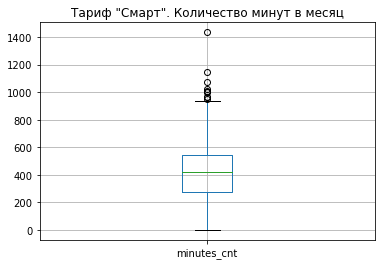

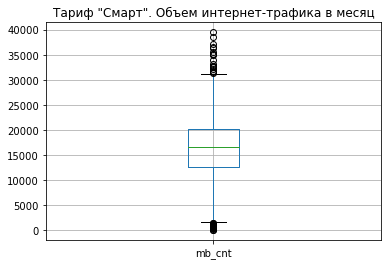

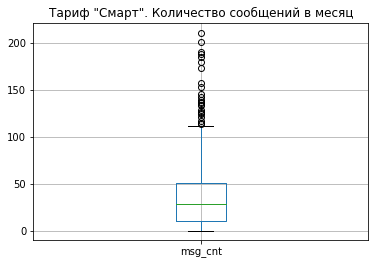

In [36]:
plt.figure()
plt.title('Тариф "Смарт". Количество минут в месяц')
total_pivot.query('tariff == "smart"').boxplot('minutes_cnt')
plt.show()

plt.figure()
plt.title('Тариф "Смарт". Объем интернет-трафика в месяц')
total_pivot.query('tariff == "smart"').boxplot('mb_cnt')
plt.show()

plt.figure()
plt.title('Тариф "Смарт". Количество сообщений в месяц')
total_pivot.query('tariff == "smart"').boxplot('msg_cnt')
plt.show()

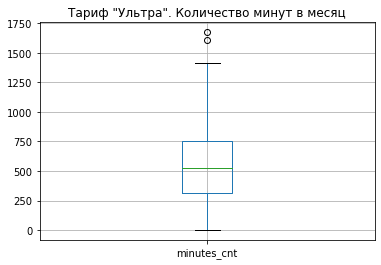

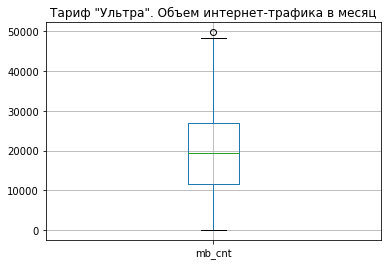

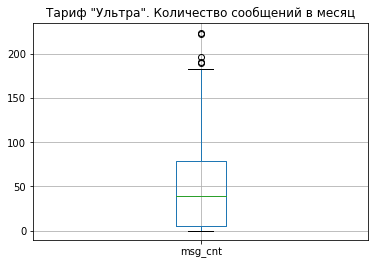

In [37]:
plt.figure()
plt.title('Тариф "Ультра". Количество минут в месяц')
total_pivot.query('tariff == "ultra"').boxplot('minutes_cnt')
plt.show()

plt.figure()
plt.title('Тариф "Ультра". Объем интернет-трафика в месяц')
total_pivot.query('tariff == "ultra"').boxplot('mb_cnt')
plt.show()

plt.figure()
plt.title('Тариф "Ультра". Количество сообщений в месяц')
total_pivot.query('tariff == "ultra"').boxplot('msg_cnt')
plt.show()

Исходя из полученных диаграмм размаха были назначены следующие границы: 
1. __Тариф "Смарт__: 
 1. Минуты: до 925 мин (превышает лимит тарифа)
 2. Объем интернет-трафика: от 1900 до 31000 Мб (превышает лимит тарифа)
 3. Количество сообщений: до 110 (превышает лимит тарифа)
2. __Тариф "Ультра"__: 
 1. Минуты: до 1500 мин (не превышает лимит тарифа)
 2. Объем интернет-трафика: до 50000 Мб (превышает лимит тарифа)
 3. Количество сообщений: до 190 (не превышает лимит тарифа)  
  
На данном этапе между абонентами разных тарифов проявляется заметная разница в поведении: пользователи тарифа "Смарт" чаще превышают лимиты, установленные тарифом. Иными словами, абонентам "Смарта" теснее в рамках тарифа.  
В то же время тариф "Ультра" выглядит гораздо "свободнее". Особенно это касается сообщений: ни один из пользователей в выборке не приблизился и к трети лимита по сообщениям, то же можно сказать и о звонках.  
Единственное, в чем абоненты разных тарифов схожи - превышение ограничения лимита интрнет-трафика. 

In [38]:
total_pivot_cnt_before = len(total_pivot)

filter_smart = '(tariff == "smart" and minutes_cnt < 925 and 1900 < mb_cnt < 31000 and msg_cnt < 110)'
filter_ultra = '(tariff == "ultra" and minutes_cnt < 1500 and mb_cnt < 50000 and msg_cnt < 190)'
filter_total = filter_smart + ' or ' + filter_ultra
total_pivot = total_pivot.query(filter_total)
total_pivot_cnt_after = len(total_pivot)
total_pivot

minutes_cnt  rub_monthly_fee  calls_extra_net_worth  \
user_id month_num                                                        
1000    5                159.0           1950.0                    0.0   
        6                172.0           1950.0                    0.0   
        7                340.0           1950.0                    0.0   
        8                408.0           1950.0                    0.0   
        9                466.0           1950.0                    0.0   
...                        ...              ...                    ...   
1498    9                471.0            550.0                    0.0   
        10               247.0            550.0                    0.0   
1499    10               449.0            550.0                    0.0   
        11               612.0            550.0                  336.0   
        12               492.0            550.0                    0.0   

                   msg_extra_net_worth  msg_cnt  mb_extra_net_worth   mb_cnt  \
user_id month_num                                                              
1000    5                          0.0     22.0                 0.0   2256.0   
        6                          0.0     60.0                 0.0  23257.0   
        7                          0.0     75.0                 0.0  14016.0   
        8                          0.0     81.0                 0.0  14070.0   
        9                          0.0     57.0                 0.0  14581.0   
...                                ...      ...                 ...      ...   
1498    9                          0.0     44.0              1329.3  22166.0   
        10                         0.0     42.0              1024.2  20604.0   
1499    10                         0.0     48.0               478.3  17809.0   
        11                        27.0     59.0               512.5  17984.0   
        12                        48.0     66.0                 0.0  13077.0   

                   total_extra_net_worth  gb_cnt  total_net_worth tariff  
user_id month_num                                                         
1000    5                            0.0    2.20           1950.0  ultra  
        6                            0.0   22.71           1950.0  ultra  
        7                            0.0   13.69           1950.0  ultra  
        8                            0.0   13.74           1950.0  ultra  
        9                            0.0   14.24           1950.0  ultra  
...                                  ...     ...              ...    ...  
1498    9                         1329.3   21.65           1879.3  smart  
        10                        1024.2   20.12           1574.2  smart  
1499    10                         478.3   17.39           1028.3  smart  
        11                         875.5   17.56           1425.5  smart  
        12                          48.0   12.77            598.0  smart  

[3114 rows x 11 columns]

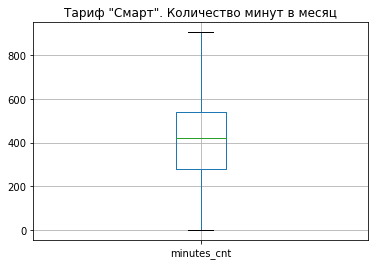

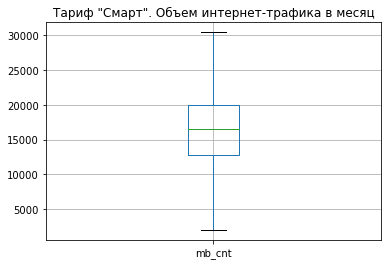

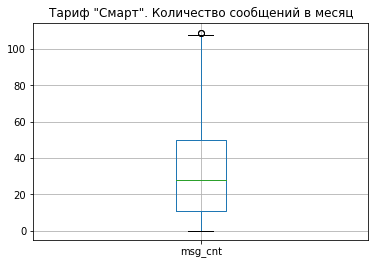

In [39]:
plt.figure()
plt.title('Тариф "Смарт". Количество минут в месяц')
total_pivot.query('tariff == "smart"').boxplot('minutes_cnt')
plt.show()

plt.figure()
plt.title('Тариф "Смарт". Объем интернет-трафика в месяц')
total_pivot.query('tariff == "smart"').boxplot('mb_cnt')
plt.show()

plt.figure()
plt.title('Тариф "Смарт". Количество сообщений в месяц')
total_pivot.query('tariff == "smart"').boxplot('msg_cnt')
plt.show()

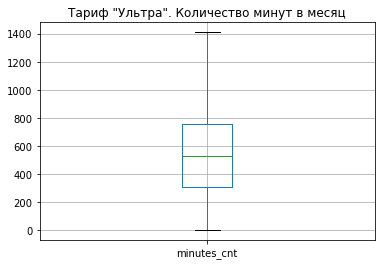

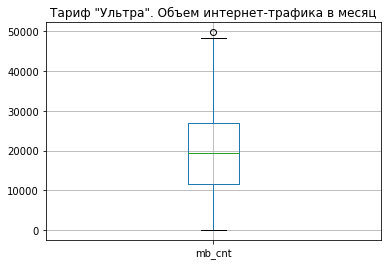

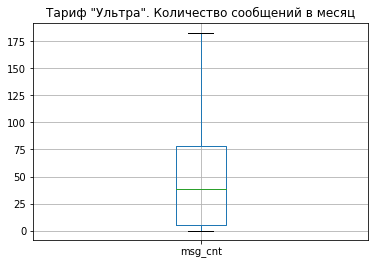

In [40]:
plt.figure()
plt.title('Тариф "Ультра". Количество минут в месяц')
total_pivot.query('tariff == "ultra"').boxplot('minutes_cnt')
plt.show()

plt.figure()
plt.title('Тариф "Ультра". Объем интернет-трафика в месяц')
total_pivot.query('tariff == "ultra"').boxplot('mb_cnt')
plt.show()

plt.figure()
plt.title('Тариф "Ультра". Количество сообщений в месяц')
total_pivot.query('tariff == "ultra"').boxplot('msg_cnt')
plt.show()

После очистки данных в таблице остались единичные выбросы, крайне близко расположенные к "усам", соответственно, их присутствие не вызовет заметного искажения данных. 

In [41]:
total_pivot_cnt_reduce = round(100 * (total_pivot_cnt_before - total_pivot_cnt_after) / total_pivot_cnt_before, 1)
print(f'Сокращение объема данных после удаления выбросов: {total_pivot_cnt_reduce}%')

Сокращение объема данных после удаления выбросов: 3.1%


In [42]:
len(total_pivot.reset_index()['user_id'].unique())

495

### Промежуточный вывод. 
В ходе очистки итоговой сводной таблице объем датафрейма сократился на 3.1%, что, помимо всего прочего, привело к удалению из рассмотрения 5 пользователей. 

## Расчет статистик выборки. 

In [43]:
mean_values = (total_pivot.pivot_table(index='tariff', values=['minutes_cnt', 'mb_cnt', 'msg_cnt', 'total_net_worth', 
                                                              'total_extra_net_worth', 'gb_cnt'])
                         .reset_index()
                         .rename(columns={'minutes_cnt': 'minutes_cnt_mean',
                                          'mb_cnt': 'mb_cnt_mean',
                                          'gb_cnt': 'gb_cnt_mean',
                                          'msg_cnt': 'msg_cnt_mean', 
                                          'total_net_worth': 'total_net_worth_mean',
                                          'total_extra_net_worth': 'total_extra_net_worth_mean'}))
mean_values['minutes_cnt_mean'] = round(mean_values['minutes_cnt_mean'], 1)
mean_values['msg_cnt_mean'] = round(mean_values['msg_cnt_mean'], 1)
print('Таблица средних значений: ')
mean_values

Таблица средних значений: 


,tariff,gb_cnt_mean,mb_cnt_mean,minutes_cnt_mean,msg_cnt_mean,total_extra_net_worth_mean,total_net_worth_mean
0,smart,15.886923,16268.174333,412.9,32.9,642.461408,1192.461408
1,ultra,19.004511,19460.739362,545.2,48.0,109.608723,2059.608723


Согласно полученным средним значениям, __абоненты тарифа "Ультра" в среднем используют услуги связи более активно__: они обходят абонентов "Смарта" по использованию всех источников трафика.  
Помимо этого, __абонент тарифа "Ультра" в среднем приносит компании больше прибыли__.  
  
Однако, __абоненты тарифа "Смарт" в среднем переплачивают за исчерпание лимита больше, чем составляет их абонентская плата__ (642 рубля переплат в дополнение к 500 рублям абонентской платы). 

In [44]:
tp_gb = (total_pivot.groupby(by='tariff')[['minutes_cnt', 'gb_cnt', 'msg_cnt']]
                    .agg([np.var, np.std,])
                    .reset_index())
print('Таблица дисперсий и стандартных отклонений:')
tp_gb

Таблица дисперсий и стандартных отклонений:


tariff   minutes_cnt                 gb_cnt                msg_cnt  \
                   var         std        var       std          var   
0  smart  34033.454691  184.481584  27.802015  5.272762   722.556401   
1  ultra  91050.639521  301.745985  97.292471  9.863695  2055.077854   

              
         std  
0  26.880409  
1  45.332967

Согласно полученным значениям стандартных отклонений, распределения показателей шире у абонентов тарифа "Ультра". Иными словами, характеристики абонентов "Ультры" варьируются в более широком диапазоне относительно тех же характеристик абонентов тарифа "Смарт". 

## Построение и анализ распределений.  
Анализ распределения месячного использования минут, сообщений и интернет-трафика для пользователей обоих тарифов.  
Распределение будет представлено частотной гистограммой и плотностным распределением. 

### Количество отправленных сообщений

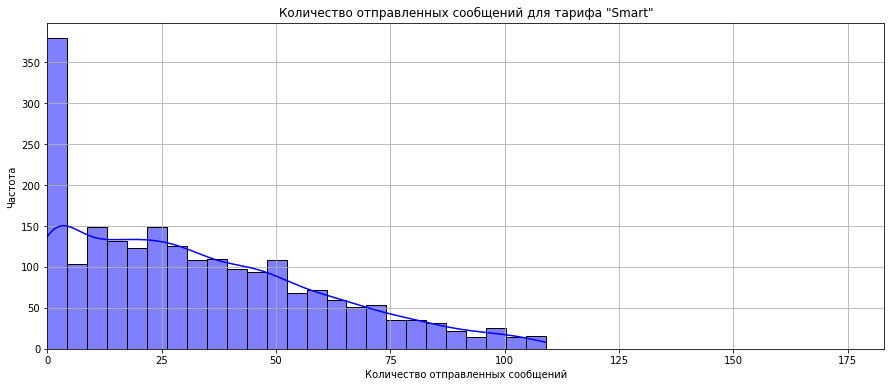

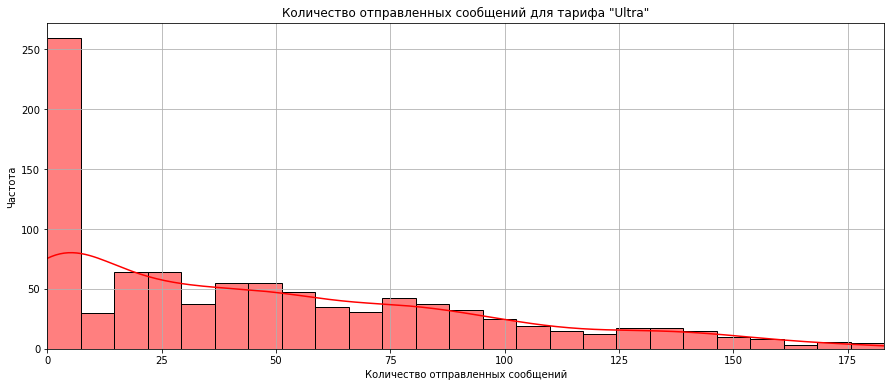

In [45]:
plt.figure(figsize=(15, 6))
plt.title('Количество отправленных сообщений для тарифа "Smart"')
plt.grid()
plt.xlim(0, total_pivot.query('tariff == "ultra"')['msg_cnt'].max())
plt.xlabel('Количество отправленных сообщений')
plt.ylabel('Частота')
sns.histplot(data=total_pivot.query('tariff == "smart"'), x="msg_cnt", kde=True, bins=25, color='blue')
plt.show()

plt.figure(figsize=(15, 6))
plt.title('Количество отправленных сообщений для тарифа "Ultra"')
plt.grid()
plt.xlim(0, total_pivot.query('tariff == "ultra"')['msg_cnt'].max())
plt.xlabel('Количество отправленных сообщений')
plt.ylabel('Частота')
sns.histplot(data=total_pivot.query('tariff == "ultra"'), x="msg_cnt", kde=True, bins=25, color='red')
plt.show()

Распределение по форме ближе всего к распределению Пуассона. В обоих случаях наблюдается максимум частоты у нуля, после чего частота монотонно понижается, формируя длинный "хвост" распределения.  
Вероятнее всего, это связано с крайне низкой востребованностью СМС-сообщений в сравнении с мессенджерами и социальными сетями.  
Также налицо смещенность распределения для тарифа "Смарт" в левую сторону относительно распределения для "Ультры". 

### Количество минут.

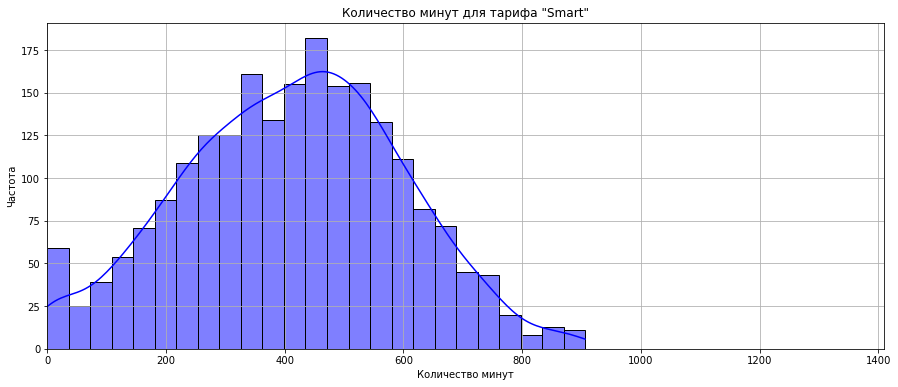

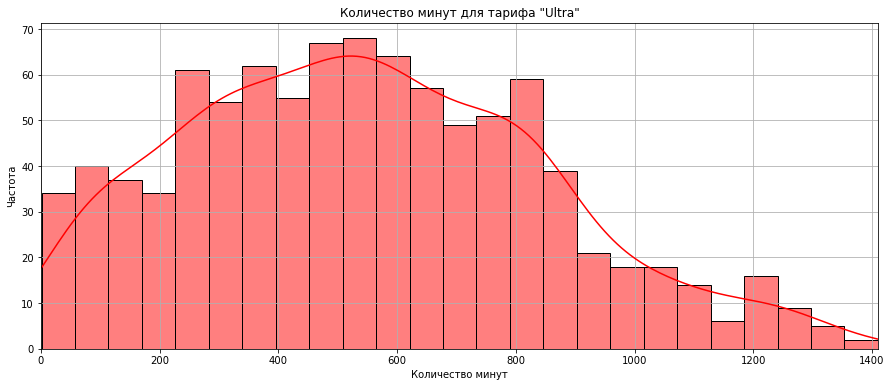

In [46]:
plt.figure(figsize=(15, 6))
plt.title('Количество минут для тарифа "Smart"')
plt.grid()
plt.xlim(0, total_pivot.query('tariff == "ultra"')['minutes_cnt'].max())
plt.xlabel('Количество минут')
plt.ylabel('Частота')
sns.histplot(data=total_pivot.query('tariff == "smart"'), x="minutes_cnt", kde=True, bins=25, color='blue')
plt.show()

plt.figure(figsize=(15, 6))
plt.title('Количество минут для тарифа "Ultra"')
plt.grid()
plt.xlabel('Количество минут')
plt.ylabel('Частота')
plt.xlim(0, total_pivot.query('tariff == "ultra"')['minutes_cnt'].max())
sns.histplot(data=total_pivot.query('tariff == "ultra"'), x="minutes_cnt", kde=True, bins=25, color='red')
plt.show()

Распределение используемых минут в обоих случаях имеет форму нормального распределения. Как и утверждалось ранее, размах распределения у тарифа "Ультра" больше, а распределение для тарифа "Смарт" смещено влево. 

### Объем интернет-трафика. 

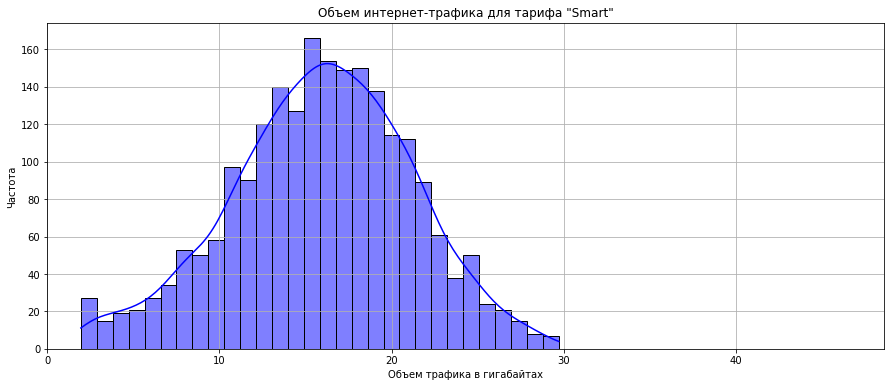

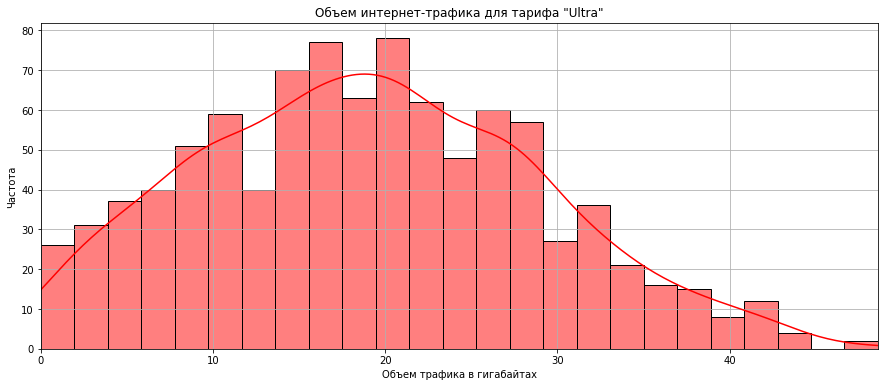

In [47]:
plt.figure(figsize=(15, 6))
plt.title('Объем интернет-трафика для тарифа "Smart"')
plt.grid()
plt.xlim(0, total_pivot.query('tariff == "ultra"')['gb_cnt'].max())
plt.xlabel('Объем трафика в гигабайтах')
plt.ylabel('Частота')
sns.histplot(data=total_pivot.query('tariff == "smart"'), x="gb_cnt", kde=True, bins=30, color='blue')
plt.show()

plt.figure(figsize=(15, 6))
plt.title('Объем интернет-трафика для тарифа "Ultra"')
plt.grid()
plt.xlim(0, total_pivot.query('tariff == "ultra"')['gb_cnt'].max())
plt.xlabel('Объем трафика в гигабайтах')
plt.ylabel('Частота')
sns.histplot(data=total_pivot.query('tariff == "ultra"'), x="gb_cnt", kde=True, bins=25, color='red')
plt.show()

Аналогичные выводы и касательно распределений объема трафика: размах шире; данные для "Ультры" смещены вправо относительно данных для "Смарта". 

### Вероятность превышения тарифа (получение дополнительной прибыли) для каждого из компонент тарифа. 

Расчет вероятности превышения тарифного лимита для минут, сообщений и мегабайт интернет-трафика для обоих тарифов.  
Данные значения отражают вероятность того, что пользователь принесет компании дополнительную прибыль.  
Ключевое допущение: распределения аппроксимированы нормальным распределением. 

In [48]:
# расчет средних для тарифа "Смарт"
smart_msg_mu   = total_pivot.query('tariff == "smart"')['msg_cnt'].mean()
smart_calls_mu = total_pivot.query('tariff == "smart"')['minutes_cnt'].mean()
smart_mb_mu    = total_pivot.query('tariff == "smart"')['mb_cnt'].mean()

#расчет стандартных отклонений для тарифа "Смарт"
smart_msg_sigma   = np.std(total_pivot.query('tariff == "smart"')['msg_cnt'], ddof=1)
smart_calls_sigma = np.std(total_pivot.query('tariff == "smart"')['minutes_cnt'], ddof=1)
smart_mb_sigma    = np.std(total_pivot.query('tariff == "smart"')['mb_cnt'], ddof=1)

#аппроксимация распределений с нормальным для тарифа "Смарт"
smart_msg_distr   = st.norm(smart_msg_mu, smart_msg_sigma)
smart_calls_distr = st.norm(smart_calls_mu, smart_calls_sigma)
smart_mb_distr    = st.norm(smart_mb_mu, smart_mb_sigma)

# расчет средних для тарифа "Ультра"
ultra_msg_mu   = np.std(total_pivot.query('tariff == "ultra"')['msg_cnt'], ddof=1)
ultra_calls_mu = np.std(total_pivot.query('tariff == "ultra"')['minutes_cnt'], ddof=1)
ultra_mb_mu    = np.std(total_pivot.query('tariff == "ultra"')['mb_cnt'], ddof=1)

#расчет стандартных отклонений для тарифа "Ультра"
ultra_msg_sigma   = np.std(total_pivot.query('tariff == "ultra"')['msg_cnt'], ddof=1)
ultra_calls_sigma = np.std(total_pivot.query('tariff == "ultra"')['minutes_cnt'], ddof=1)
ultra_mb_sigma    = np.std(total_pivot.query('tariff == "ultra"')['mb_cnt'], ddof=1)

#аппроксимация распределений с нормальным для тарифа "Ультра"
ultra_msg_distr   = st.norm(ultra_msg_mu, ultra_msg_sigma)
ultra_calls_distr = st.norm(ultra_calls_mu, ultra_calls_sigma)
ultra_mb_distr    = st.norm(ultra_mb_mu, ultra_mb_sigma)

In [49]:
#расчет вероятностей для тарифа "Смарт"
smart_msg_lim   = round(100 * (1 - smart_msg_distr.cdf(50)), 1)
smart_calls_lim = round(100 * (1 - smart_calls_distr.cdf(500)), 1)
smart_mb_lim    = round(100 * (1 - smart_mb_distr.cdf(15 * 1024)), 1)

#расчет вероятностей для тарифа "Ультра"
ultra_msg_lim   = round(100 * (1 - ultra_msg_distr.cdf(1000)), 1)
ultra_calls_lim = round(100 * (1 - ultra_calls_distr.cdf(3000)), 1)
ultra_mb_lim    = round(100 * (1 - ultra_mb_distr.cdf(30 * 1024)), 1)

In [50]:
print('Тариф "Смарт". Вероятности превышения тарифного лимита')
print(f'Сообщения:       {(smart_msg_lim)}%')
print(f'Минуты:          {(smart_calls_lim)}%')
print(f'Интернет-трафик: {(smart_mb_lim)}%')
print()
print('Тариф "Ультра". Вероятности превышения тарифного лимита')
print(f'Сообщения:       {(ultra_msg_lim)}%')
print(f'Минуты:          {(ultra_calls_lim)}%')
print(f'Интернет-трафик: {(ultra_mb_lim)}%')

Тариф "Смарт". Вероятности превышения тарифного лимита
Сообщения:       26.3%
Минуты:          31.8%
Интернет-трафик: 56.7%

Тариф "Ультра". Вероятности превышения тарифного лимита
Сообщения:       0.0%
Минуты:          0.0%
Интернет-трафик: 2.1%


#### Промежуточный вывод.
Если аппроксимировать распределения пунктов тарифного плана нормальным распределением, наиболее выгодным с точки зрения переплат является тариф "Смарт": пользователи приносят значительную дополнительную прибыль по всем пунктам тарифа.  
__Если тариф "Смарт" со стороны оператора содержать дешевле, то выгоднее вложиться в его рекламное продвижение.__

### Промежуточный вывод. 
- Формы распределений соответствуют полученым ранее статистикам. Ключевые особенности: 
1. __Размах распределений__ больше у тарифа "Ультра", причем для всех показателей
2. __Пиковые значения частоты__ у распределений для тарифа "Смарт" выше (иногда почти в 3 раза), что связано с тем, что в начальной выборке пользователей этого тарифа в два раза больше 
3. Для всех показателей распределения для тарифа "Смарт" __смещены влево__, что вызвано меньшим объемом минут, СМС и трафика, доступных за абонентскую плату. 
4. __Форма распределения__ всех показателей, кроме сообщений, __совпадает с нормальным__. У распределения сообщений форма совпадает с формой __распределения Пуассона__ 
5. Тарифы схожи тем, что в обоих случаях распределение для сообщений __резко скошено влево__, что связано с низкой востребованностью СМС-сообщений, как средства связи. В данной выборке пользователи ни одного из тарифов не превышают лимит по сообщениям. 
  
 
 
- На основании статистики по переплатам наиболее выгоден тариф "Смарт" (в случае, если его содержание обходится компании дешевле). 

## Проверка гипотез. 
### Гипотеза №1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. 

#### Нулевая гипотеза
_Средние выручки от абонентов тарифов "Смарт" и "Ультра" равны._  
#### Альтернативная гипотеза
_Средние выручки от абонетов тарифов "Смарт" и "Ультра" различны._
  
Важно! Ранее при анализе "трат" пользователей было установлено, что по всем аспектам (звонки, СМС, интернет) абоненты разных тарифов отличаются.  
Соответственно, при проведении статистических тестов __дисперсии выборок будем считать разными__.  
__Уровень статистической значимости примем равным 5%__. 

In [51]:
#вычленение исследуемых выборок
smart = total_pivot.reset_index().query('tariff == "smart"')['total_net_worth']
ultra = total_pivot.reset_index().query('tariff == "ultra"')['total_net_worth']

print('Объем выборки для тарифа "Смарт":', len(smart))
print('Объем выборки для тарифа "Ультра":', len(ultra))
print('Соотношение объемов выборок:', round(len(smart) / len(ultra), 1))

Объем выборки для тарифа "Смарт": 2174
Объем выборки для тарифа "Ультра": 940
Соотношение объемов выборок: 2.3


In [52]:
results = st.ttest_ind(smart, ultra, equal_var=False)

alpha = 0.05

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha): 
    print('Нулевая гипотеза опровергнута')
else: 
    print('Не удалось опровергнуть нулевую гипотезу')

p-значение:  0.0
Нулевая гипотеза опровергнута


#### Промежуточный вывод: 
__средняя выручка пользователей разных тарифов различна__.  
  
Параметры теста: 
1. Уровень статистической значимости: 5%
2. Выборки имеют разные дисперсии
3. Объемы выборок: 
 1. "Смарт": 2174
 2. "Ультра": 940
 3. Соотношение объемов: 2.3

### Гипотеза №2. Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

#### Нулевая гипотеза
_Средние выручки пользователей из Москвы и других регионов равны_

#### Альтернативная гипотеза
_Средние выручки пользователей из Москвы и других регионов различны_

In [53]:
#вычленение исследуемых выборок
moscow_users = users.query('city == "Москва"')['user_id']
other_cities_users = users.query('city != "Москва"')['user_id']

In [54]:
moscow_users_data = total_pivot.reset_index().query('user_id in @moscow_users')
moscow_users_cnt = len(moscow_users_data['user_id'].unique())
print(f'Количество пользователей из Москвы: {moscow_users_cnt}')

other_cities_users_data = total_pivot.reset_index().query('user_id in @other_cities_users')
other_cities_users_cnt = len(other_cities_users_data['user_id'].unique())
print(f'Количество пользователей из других городов: {other_cities_users_cnt}')
print()
print('Объем выборки с абонентами из Москвы:', len(moscow_users_data))
print('Объем выборки с абонентами из других регионов:', len(other_cities_users_data))
print('Соотношение объемов выборок:', round(len(other_cities_users_data) / len(moscow_users_data), 1))

Количество пользователей из Москвы: 99
Количество пользователей из других городов: 396

Объем выборки с абонентами из Москвы: 602
Объем выборки с абонентами из других регионов: 2512
Соотношение объемов выборок: 4.2


Очевидно, на этапе очистки итоговой таблицы от выбросов (см. пункт 1.5) все 5 удаленных пользователей проживают в регионах. 

In [55]:
results = st.ttest_ind(moscow_users_data['total_net_worth'], other_cities_users_data['total_net_worth'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Нулевая гипотеза опровергнута')
else:
    print('Не удалось опровергнуть нулевую гипотезу')

p-значение: 0.0793786269657511
Не удалось опровергнуть нулевую гипотезу


#### Промежуточный вывод. 
Согласно проведенному t-тесту, __средние выручки от абонентов из Москвы и абонентов из других регионов равны.__
  
  
Параметры теста: 
1. Уровень статистической значимости: 5%
2. Выборки приняты равными по дисперсии
3. Объемы выборок: 
 1. Данные по абонентам из Москвы: 602
 2. Данные по абонентам из других регионов: 2512
 3. Соотношения объемов выборок: 4.2

### Промежуточный вывод.
Результаты статистического тестирования: 
1. __Средняя выручка__ от абонентов тарифа "Смарт" __отличается__ от средней выручки от абонентов тарифа "Ультра"
2. __Средняя выручка__ от абонентов из Москвы __равна__ средней выручке от абонентов из других регионов

## Общий вывод

В ходе выполнения проекта: 
1. __Данные исследованы__ отдельно в рамках исходных таблиц
2. Была проведена __замена типов данных__
3. В таблицы были __добавлены новые колонки__ с преобразованными величинами
4. __Нулевые значеня__ были удалены
5. Были __проведены расчеты__ значений суммарной выручки и выручки от отдельных компонентов тарифа
6. Данные были __собраны в общую__ сводную __таблицу__
7. Общая сводная таблица была __очищена от выбросов__
8. Для очищенной сводной таблицы были проведены __расчеты статистик, построены__ частотные и плотностные __распределения__
9. На основании очищенных данных были __расчитаны вероятности__ того что пользователь принесет дополнительную прибыль за счет превышения тарифа
10. Были __проверены статистические гипотезы__, связанные с прибыльностью абонентов и тарифов.

__При корректировке рекламного бюджета необходимо учесть следующее:__ 
1. Абоненты тарифа "Смарт" переплачивают значительно чаще, чем абоненты тарифа "Ультра"
 - _за сообщения_: 26.3% случаев (против 0% для "Ультры)
 - _за минуты_   : 31.8% случаев (против 0% для "Ультры)
 - _за интернет_ : 56.7% случаев (против 2.1% для "Ультры)
2. Средняя выручка от абонентов тарифа "Смарт" не равна средней выручке от абонентов тарифа "Ультра"
3. Средняя выручка от абонентов из Москвы не отличается от средней выручки от абонентов из регионов